# 3. Seasonality

We say that a time series exhibits **seasonality** whenever there is a `regular, periodic change in the mean of the series`. Seasonal changes generally follow the clock and calendar -- repetitions over a day, a week, or a year are common. Seasonality is often driven by the cycles of the natural world over days and years or by conventions of social behavior surrounding dates and times.

Below figure shows 4 example seasonality pattern:

![03.ts_seasonality_exp.png](../img/03.ts_seasonality_exp.png)

In this section, we will learn two kinds of features that model seasonality:
1. **indicators**: it is best for a season with few observations, like a weekly season of daily observations.
2. **Fourier features**: it is best for a season with many observations, like an annual season of daily observations.

## 3.1 Seasonal Plots and Seasonal Indicators

Just like we used a moving average plot to discover the trend in a series, we can use a **seasonal plot** to discover seasonal patterns.

A seasonal plot shows segments of the time series plotted against some common period, the period being the "season" you want to observe. The figure shows a seasonal plot of the daily views of Wikipedia's article on Trigonometry: the article's daily views plotted over a common weekly period.

![03.ts_seasonality_plot.png](../img/03.ts_seasonality_plot.png)

There is a clear weekly seasonal pattern in this series, higher on weekdays and falling towards the weekend.

## 3.1.1 Seasonal indicators
**Seasonal indicators** are binary features that represent seasonal differences in the level of a time series. Seasonal indicators are what you get if you treat a seasonal period as a categorical feature and apply one-hot encoding.

By one-hot encoding days of the week, we get weekly seasonal indicators. Creating weekly indicators for the `Trigonometry` series will then give us six new "dummy" features. (Linear regression works best if you drop one of the indicators; we chose Monday in the frame below.)

```text
Date	Tuesday	Wednesday	Thursday	Friday	Saturday	Sunday
2016-01-04	0.0	0.0	0.0	0.0	0.0	0.0
2016-01-05	1.0	0.0	0.0	0.0	0.0	0.0
2016-01-06	0.0	1.0	0.0	0.0	0.0	0.0
2016-01-07	0.0	0.0	1.0	0.0	0.0	0.0
2016-01-08	0.0	0.0	0.0	1.0	0.0	0.0
2016-01-09	0.0	0.0	0.0	0.0	1.0	0.0
2016-01-10	0.0	0.0	0.0	0.0	0.0	1.0
2016-01-11	0.0	0.0	0.0	0.0	0.0	0.0
...	...	...	...	...	...	...
```


Adding seasonal indicators to the training data helps models distinguish means within a seasonal period:

![03.ts_seasonality_plot_indicator.png](../img/03.ts_seasonality_plot_indicator.png)

The indicators act as On / Off switches. At any time, at most one of these indicators can have a value of `1` (On). Linear regression learns a baseline value `2379` for Mon and then adjusts by the value of whichever indicator is On for that day; the rest are `0` and vanish.

### 3.1.2 Fourier Features and the Periodogram

`Fourier feature` are better suited for long seasons over many observations where indicators would be impractical. Instead of creating a feature for each date, Fourier features try to capture the overall shape of the seasonal curve with just a few features.

Let's take a look at a plot for the annual season in `Trigonometry`. Notice the repetitions of various frequencies: a long up-and-down movement three times a year, short weekly movements 52 times a year, and perhaps others.

Below figure shows the `annual seasonality in the Wiki Trigonometry series`.

![03.ts_seasonality_plot_fourier.png](../img/03.ts_seasonality_plot_fourier.png)

It is these frequencies within a season that we attempt to capture with Fourier features. The idea is to include in our training data periodic curves having the same frequencies as the season we are trying to model. The curves we use are those of the trigonometric functions sine and cosine.

**Fourier features are pairs of sine and cosine curves**, one pair for each potential frequency in the season starting with the longest. Fourier pairs modeling annual seasonality would have frequencies: once per year, twice per year, three times per year, and so on.

Below figure shows the first two `Fourier pairs` for annual seasonality. Top: Frequency of once per year. Bottom: Frequency of twice per year.

![03.ts_seasonality_plot_fourier_pair.png](../img/03.ts_seasonality_plot_fourier_pair.png)

If we add a set of these sine / cosine curves to our training data, the linear regression algorithm will figure out the weights that will fit the seasonal component in the target series. The below figure illustrates how linear regression used four Fourier pairs to model the annual seasonality in the Wiki Trigonometry series. Top: Curves for four Fourier pairs, a sum of sine and cosine with regression coefficients. Each curve models a different frequency. Bottom: The sum of these curves approximates the seasonal pattern.

![03.ts_seasonality_plot_fourier_component.png](../img/03.ts_seasonality_plot_fourier_component.png)

Notice that we only needed eight features (four sine / cosine pairs) to get a good estimate of the annual seasonality. Compare this to the seasonal indicator method which would have required hundreds of features (one for each day of the year). By modeling only the "main effect" of the seasonality with Fourier features, you'll usually need to add far fewer features to your training data, which means reduced computation time and less risk of overfitting.

## 3.2 Choosing Fourier features with the Periodogram
How many Fourier pairs should we actually include in our feature set? We can answer this question with the periodogram. The periodogram tells you the strength of the frequencies in a time series. Specifically, the value on the y-axis of the graph is (a ** 2 + b ** 2) / 2, where a and b are the coefficients of the sine and cosine at that frequency (as in the Fourier Components plot above).

Below figure shows the periodogram for the Wiki Trigonometry series.

![03.ts_seasonality_plot_periodogram.png](../img/03.ts_seasonality_plot_periodogram.png)

From left to right, the periodogram drops off after Quarterly, four times a year. That was why we chose four Fourier pairs to model the annual season. The Weekly frequency we ignore since it's better modeled with indicators.

### 3.2.1 Computing Fourier features (optional)

Knowing how Fourier features are computed isn't essential to using them, but if seeing the details would clarify things, the code below illustrates how a set of Fourier features could be derived from the index of a time series. (We'll use a library function from statsmodels for our applications, however.)

```python
import numpy as np


def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)


# Compute Fourier features to the 4th order (8 new features) for a
# series y with daily observations and annual seasonality:
#
# fourier_features(y, freq=365.25, order=4)
```

## 3.3 Application example

We'll continue once more with the `Tunnel Traffic` dataset. First we will define two functions:
- `seasonal_plot`
- `plot_periodogram`

In [1]:
from warnings import simplefilter
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [3]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [4]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax



In [5]:
data_path = "../data/tunnel.csv"
tunnel = pd.read_csv(data_path, parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period("D")

In [6]:
tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


### 3.3.1 Generate seasonal plots

Let's first generate a seasonal plot over a week and over a year.

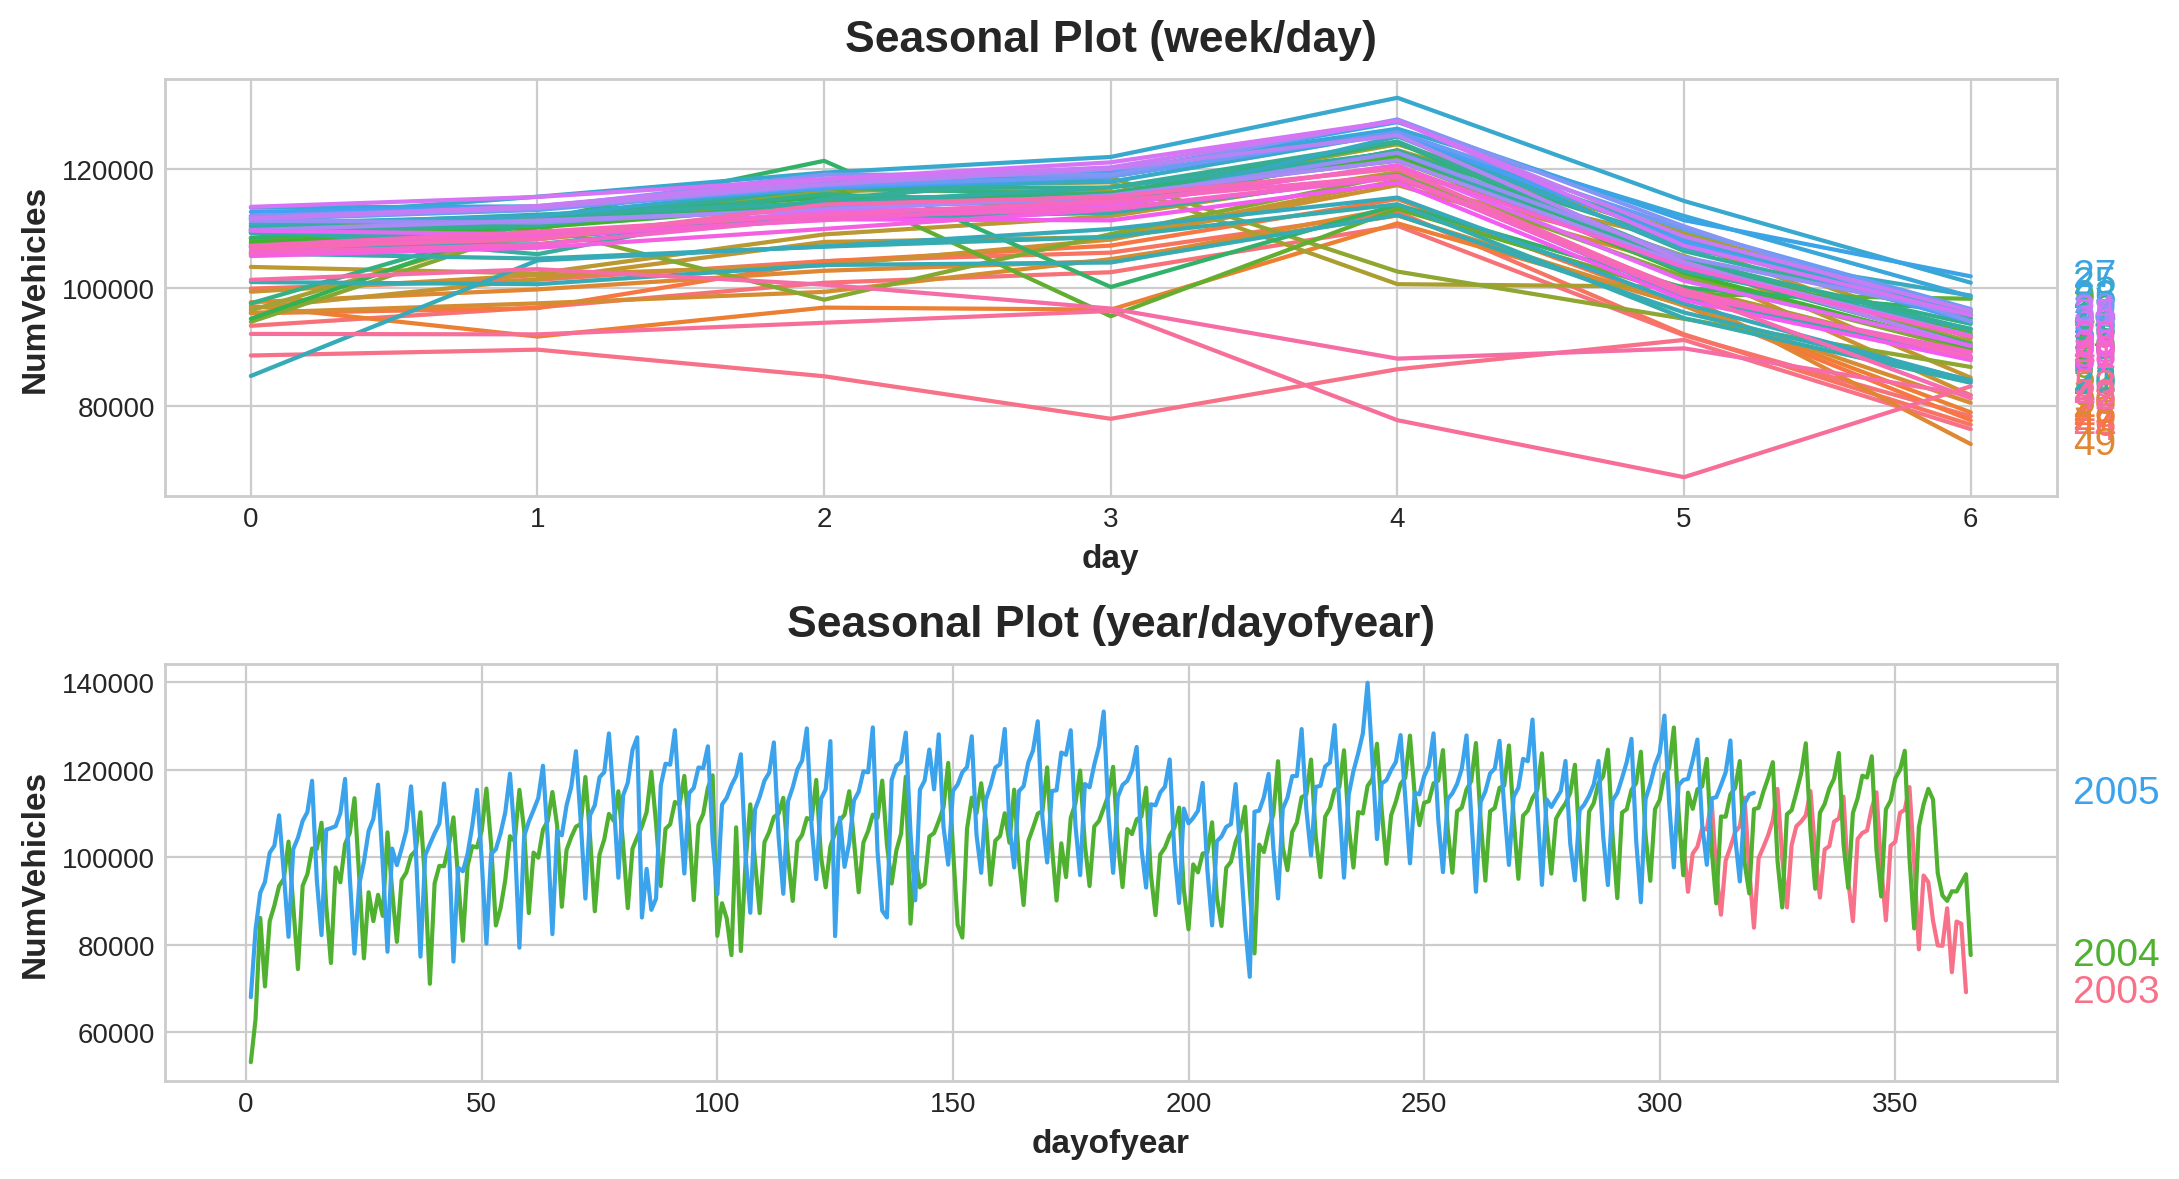

In [7]:
X = tunnel.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="NumVehicles", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="NumVehicles", period="year", freq="dayofyear", ax=ax1);

### 3.3.2 Generate the periodogram

Now let's look at the periodogram

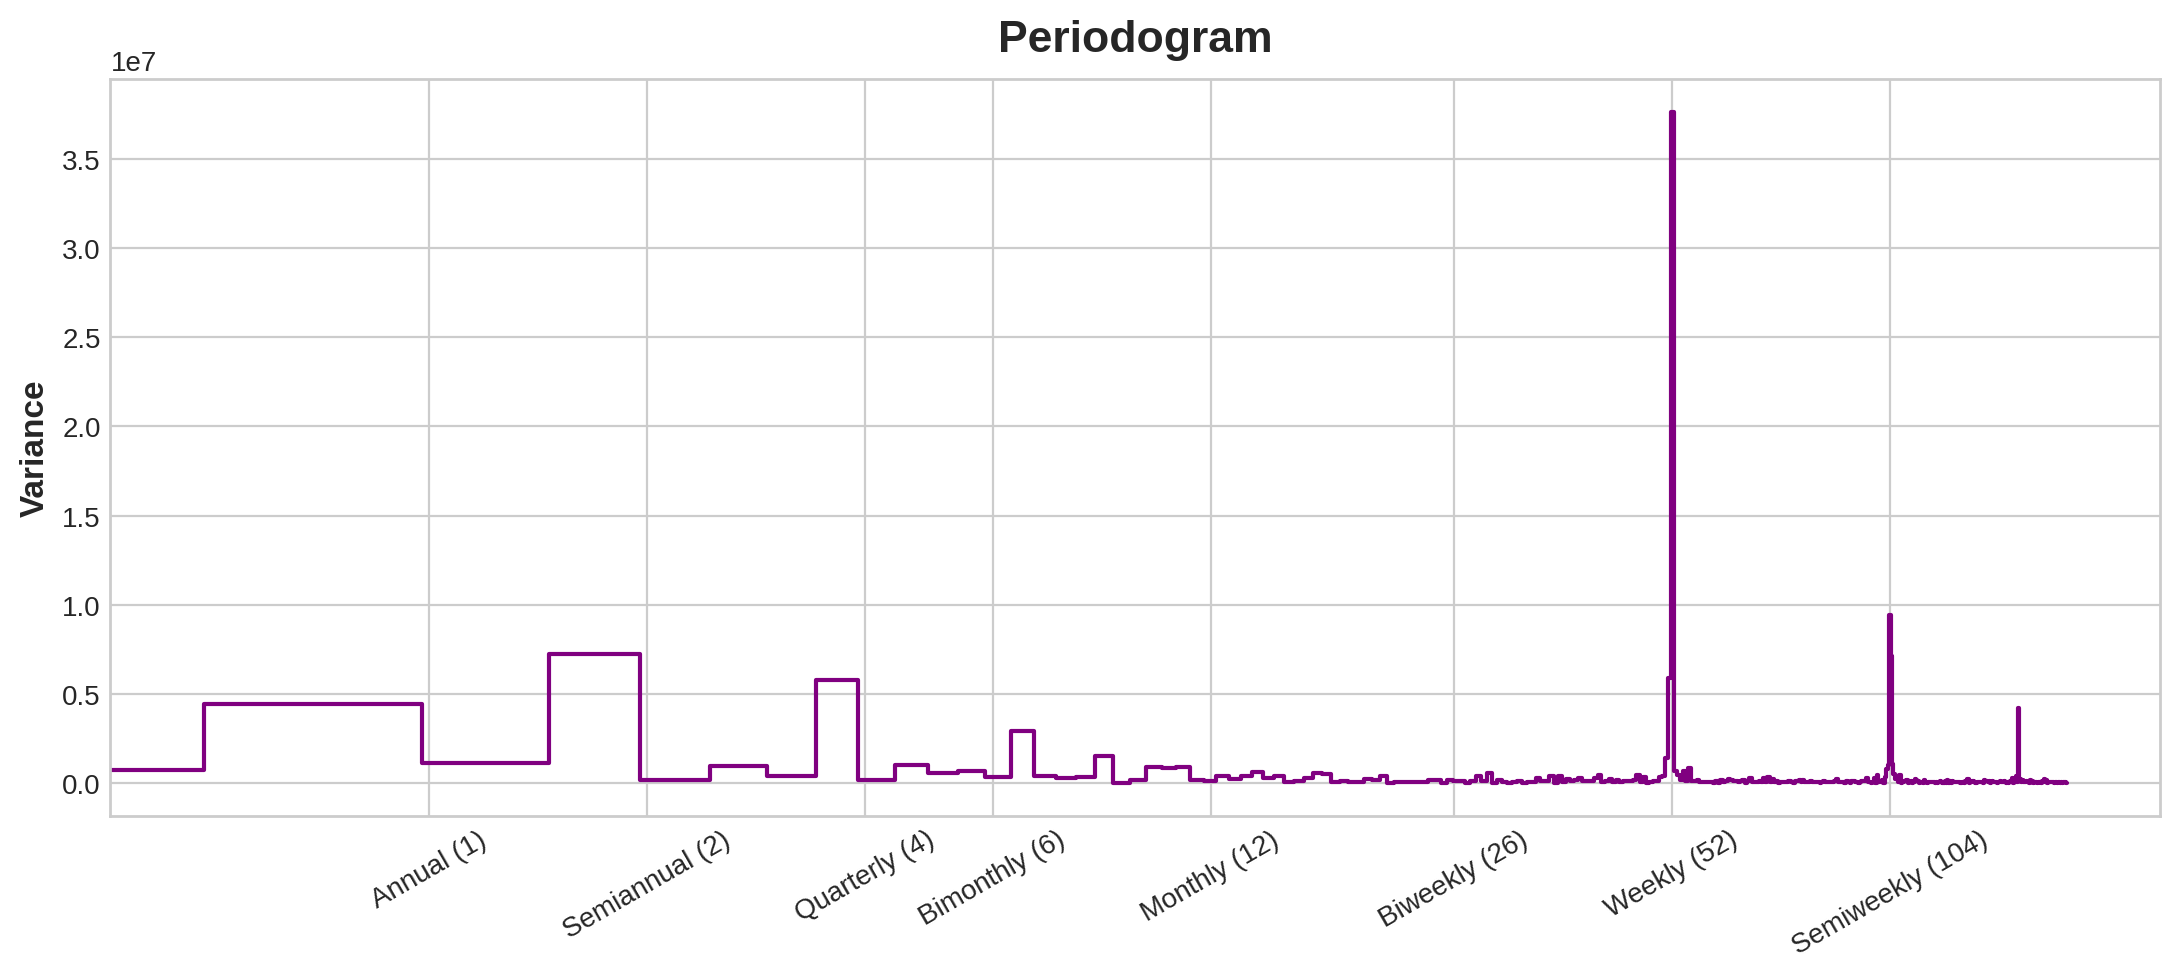

In [8]:
plot_periodogram(tunnel.NumVehicles);

The **periodogram agrees with the seasonal plots** above: a strong weekly season and a weaker annual season. The weekly season we'll model with indicators and the annual season with Fourier features. From right to left, the periodogram falls off between Bimonthly (6) and Monthly (12), so let's use 10 Fourier pairs.

We'll create our seasonal features using `DeterministicProcess`, the same utility we used in Lesson 2 to create trend features. To use two seasonal periods (weekly and annual), we'll need to instantiate one of them as an "additional term":

In [9]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=tunnel.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

With our feature set created, we're ready to fit the model and make predictions. We'll add a 90-day forecast to see how our model extrapolates beyond the training data. The code here is the same as that in earlier lessons.

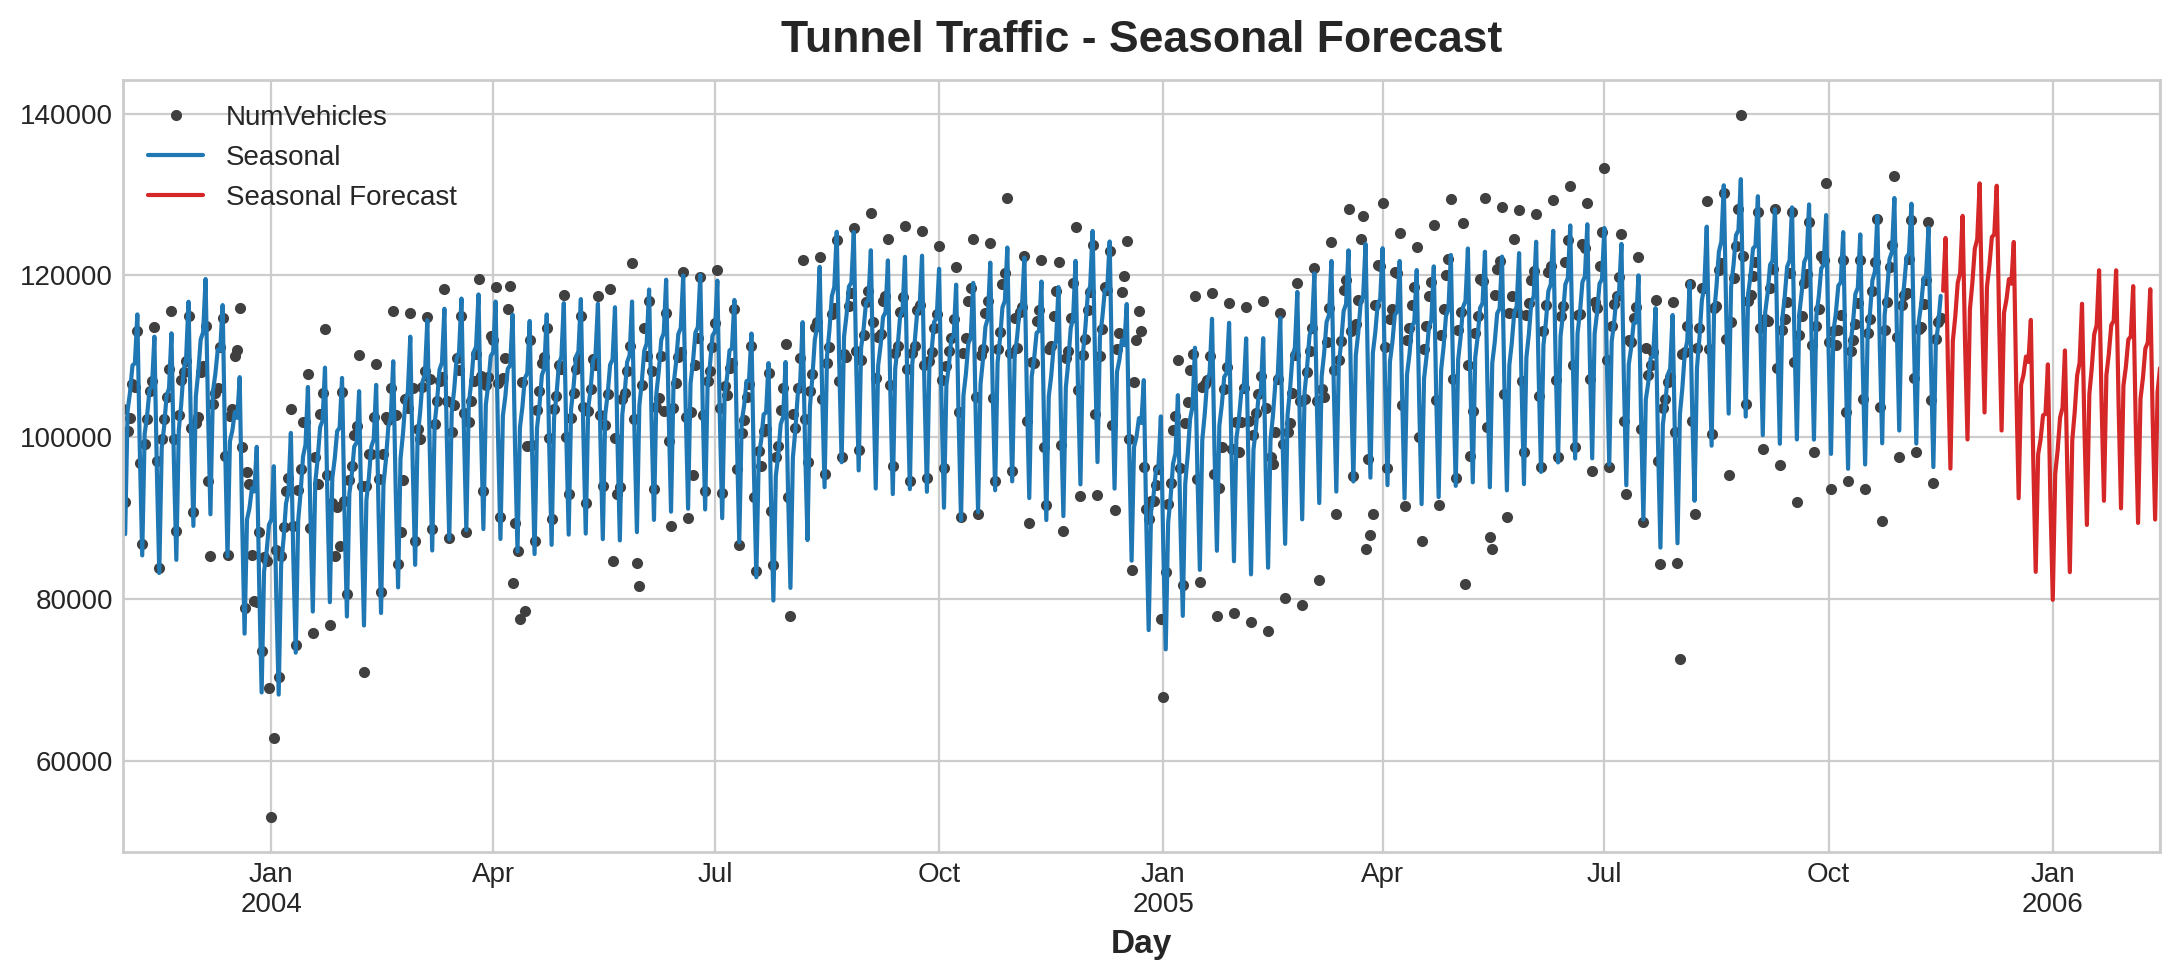

In [10]:
y = tunnel["NumVehicles"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()